In [22]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial.distance import cdist
from PIL import Image

from lib.file.TIF import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.utilities import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter

# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


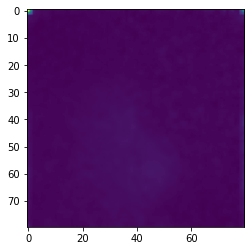

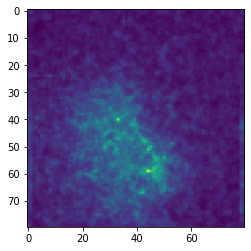

In [6]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/02-07-24/selected_zda/"
target_recording = '02_01_01'
tdTomato_rois = data_dir + 'ROIs-red' + target_recording + '.dat'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1

ROI_px_cutoff = 9
SNR_cutoff = 2.5
Amp_cutoff = 1

data = {}
for fn in ['_amp.dat', '_snr.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

n, m = data['_amp.dat'].shape

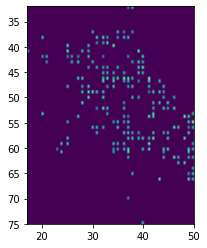

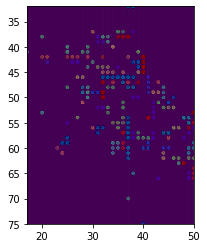

Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/02-07-24/selected_zda/ROIs-GMM-02_01_01_96-99.dat


In [9]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]
roi = GMM_ROI_Identifier()
reg_exp = RegionExporter()

percentile_strata = [[96, 99]]
k_cluster = 90
sampling_size = 10000

snr = data['_snr.dat']
w, h = snr.shape
cluster_strata = []

for stratum in percentile_strata:
    low_cutoff, hi_cutoff = stratum

    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                            percentile_cutoff=low_cutoff,
                                            upper_cutoff=hi_cutoff)

    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
    k = k_cluster

    if k is None:
        # use AIC and elbow method, then enter choice of k above
        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
        break
    else: # after manually selecting k
        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

        # print ROIs to a DAT file to be loaded into PhotoZ
        filename = data_dir + "ROIs-GMM-" + target_recording + "_" + str(low_cutoff) + "-" + str(hi_cutoff) + ".dat"
        roi_write = ROIFileWriter()
        regions = roi_write.export_clusters(filename, labels, sampled_points, w)
        all_regions_by_pixel = roi_write.get_regions_by_pixel()
        # regions is in format of doubly-nested list of PhotoZ diode numbers

        cluster_objs = []
        for px_region in all_regions_by_pixel:
            cluster_objs.append(Cluster(px_region, w))
            
        cluster_strata.append(cluster_objs)
        data['gmm-rois-filename'] = filename

number of ROIs: 1
[[[69, 43], [58, 35], [71, 31], [62, 26], [54, 22], [59, 18], [64, 15], [72, 8], [62, 7], [61, 4], [56, 14], [47, 12], [46, 25], [43, 22], [43, 26], [39, 20], [54, 32], [51, 33], [47, 33], [42, 33], [48, 28], [35, 6], [35, 17], [39, 41], [35, 44], [32, 45], [29, 46], [27, 48], [26, 44], [28, 42], [31, 40], [33, 41], [35, 37], [37, 35], [32, 34], [27, 37], [25, 40], [23, 41], [18, 48], [18, 40], [19, 37], [16, 39], [13, 38], [14, 33], [11, 33], [18, 33], [21, 31], [29, 31], [33, 28], [28, 25], [28, 26], [25, 28], [21, 28], [26, 24], [27, 23], [30, 22], [25, 17], [21, 19], [21, 21], [18, 21], [15, 21], [11, 20], [7, 22], [6, 15], [7, 11], [12, 7], [16, 7], [14, 5], [17, 15], [14, 14], [12, 16], [16, 10], [21, 8], [27, 4], [28, 11], [18, 27], [15, 29], [12, 29], [14, 24], [11, 24], [41, 47], [37, 48], [33, 50], [32, 54], [27, 53], [28, 59], [35, 60], [37, 57], [39, 52], [42, 52], [44, 54], [46, 50], [44, 46], [50, 57], [49, 59], [50, 59], [43, 60], [49, 64], [63, 66], [7

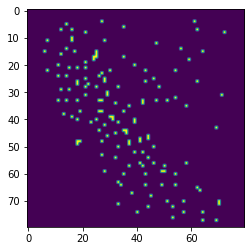

147.0
number of ROIs: 90
[[[38, 50], [39, 50]], [[27, 43], [26, 43]], [[49, 65], [49, 66]], [[38, 58], [38, 57]], [[35, 44]], [[49, 57], [48, 58], [50, 56]], [[32, 52], [31, 52]], [[25, 55]], [[38, 37]], [[43, 66]], [[42, 53], [42, 51], [42, 58], [42, 54], [42, 57], [42, 52]], [[31, 39], [31, 38], [32, 39]], [[21, 43]], [[41, 46], [41, 47], [41, 48], [41, 49]], [[44, 60], [45, 60]], [[30, 49], [31, 49]], [[41, 60], [40, 60], [41, 59]], [[45, 51], [46, 50]], [[40, 75]], [[31, 57], [31, 56], [32, 56]], [[39, 43], [39, 44], [38, 43]], [[25, 59], [24, 59], [25, 58]], [[34, 46], [36, 46], [38, 46], [37, 46], [35, 46], [33, 46], [32, 46]], [[37, 56], [37, 57], [37, 54], [37, 55], [37, 58]], [[38, 32], [37, 32]], [[37, 61], [37, 62], [37, 60]], [[44, 57], [45, 57]], [[38, 48], [37, 48], [36, 47]], [[49, 54], [48, 54], [49, 55]], [[28, 49], [28, 48]], [[49, 60], [50, 60], [50, 59], [49, 61]], [[38, 65]], [[44, 49], [44, 50], [44, 48]], [[20, 53]], [[34, 60], [35, 59], [34, 61], [35, 60], [34, 

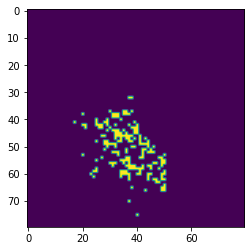

192.0


In [15]:
# read in red labels and hVOS labels
roi_maps = []
hvos_rois = data['gmm-rois-filename']
for rois_filename in [tdTomato_rois, hvos_rois]:
    rfr = ROIFileReader(rois_filename)
    rois = rfr.get_roi_list()

    print("number of ROIs:", len(rois))
    rois = [LaminarROI(rr).get_points() for rr in rois]
    print(rois, len(rois))
    roi_map = np.zeros((n, m))
    for roi in rois:
        for px in roi:
            i, j = px
            roi_map[j][i] = 1
    plt.imshow(roi_map)
    plt.show()
    print(np.sum(roi_map))
    roi_maps.append(roi_map)



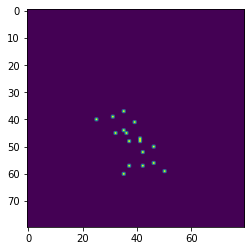

17


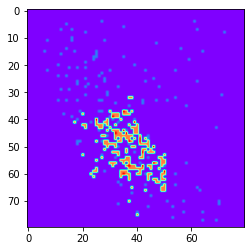

In [12]:
# overlap of red_roi_map and kkm_roi_map
red_roi_map, gmm_roi_map = roi_maps
overlap_map = np.logical_and(red_roi_map, gmm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + gmm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')

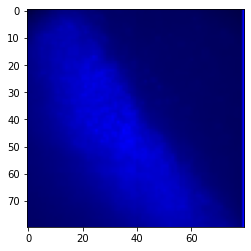

0.0 34.099


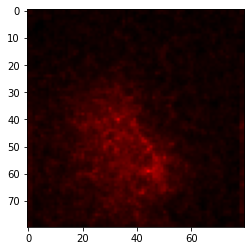

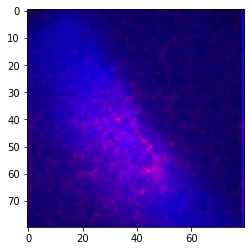

In [72]:

# plot the mCherry intensity as a red image
mCherry_intensity_map = data_dir + 'bkg-mCherry-intensity.png'
mCherry_intensity = np.array(Image.open(mCherry_intensity_map).getdata()).reshape((n, m, 4))
mCherry_intensity[:, :, 2] =  np.average(mCherry_intensity, axis=2)
mCherry_intensity[:, :, 1] = 0
mCherry_intensity[:, :, 0] = 0
min_intensity = np.min(mCherry_intensity[:, :, 0])
max_intensity = np.max(mCherry_intensity[:, :, 0])

# normalize mCherry_intensity 0 - 255
mCherry_intensity[:, :, 2] = (mCherry_intensity[:, :, 2] - min_intensity)
mCherry_intensity = mCherry_intensity[:, :,:3]
plt.imshow(mCherry_intensity)
plt.show()

# plot the hVOS snr as a green image
hvos_snr_map = np.zeros((n, m, 3))
min_intensity = np.min(data['_snr.dat'])
max_intensity = np.max(data['_snr.dat'])
print(min_intensity, max_intensity)
hvos_snr_map[:, :, 0] = 255 * (data['_snr.dat'] - min_intensity) / (max_intensity - min_intensity)
hvos_snr_map = hvos_snr_map.astype(np.uint8)
plt.imshow(hvos_snr_map)
plt.show()

# merge the images
merged = hvos_snr_map + mCherry_intensity
plt.imshow(merged)
plt.show()